In [1]:
from typing import List, Dict
import os
import subprocess
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def parse_experimental_results(simfile: str):
    sample = simfile.split("_")[1]
    lines = []
    with open(simfile) as f:
        lines = f.readlines()
    array = []
    for line in lines:
        new_line = []
        striped = line.strip().split("   ")
        for e in striped:
            new_line.append(float(e))
        array.append(new_line)   
    df_exp = pd.DataFrame(array, columns = ["time", "diff_length", "D_D0", "uncertainty"])
    return {'sample': sample, 'data': df_exp}

def parse_sim_results(simfile: str, cols: List[str]):
    data = {}
    df = pd.read_csv(simfile)
    for col in cols:
        data[col] = df[col].values
    return data

def parse_dirname(dirname: str):
    data = {}
    tokens = dirname.split('/')[-1].split('_')
    data['sample'] = tokens[2]
    for t in tokens[3:]:
        k,v = t.split('=')
        data[k] = v
    return data
    

def pade_approx(times: np.ndarray, 
                D0: float, 
                svp: float, 
                tort_limit: float, 
                tort_time: float) -> np.ndarray:
    ''' 
    This function returns a Padé approximation of the diffusivity function
    '''
    term_a = (1.0 - tort_limit)
    term_b = ((4.0 * np.sqrt(D0)) / (9.0 * np.pi)) * svp
    term_sqrt = term_b * np.sqrt(times)
    term_linear = term_a * (D0/(D0*tort_time)) * times
    term_div = term_a + term_sqrt + term_linear
    return (1.0 - term_a * (term_sqrt + term_linear) / term_div)

def fit_pade_params(times: np.ndarray, 
                    ydata: np.ndarray, 
                    D0: float, 
                    bounds: List[List] = None, 
                    refac: bool = False) -> Dict:
    '''
    This functions returns Padé aproximation params for diffusivity curve
    '''
    fitting_bounds = [[0.999999*D0], [D0]]
    if(bounds):
        fitting_bounds[0].extend(bounds[0])
        fitting_bounds[1].extend(bounds[1])
    else:
        fitting_bounds[0].extend([0.0, 0.0, 0.0])
        fitting_bounds[1].extend([np.inf, 1.0, np.inf])
        
    popt, pcov = curve_fit(pade_approx, times, ydata, bounds=tuple(fitting_bounds))
    if(refac):
        r = 3.0 / popt[1]
        theta_min = r**2 / D0
        theta_max = (10.0 * r)**2 / D0
        fitting_bounds[0][3] = theta_min
        fitting_bounds[1][3] = theta_max
        popt, pcov = curve_fit(pade_approx, times, ydata, bounds=tuple(fitting_bounds))
    
    params = {
        'D0': popt[0],
        'SVp': popt[1],
        'tort_limit': popt[2],
        'theta': popt[3],
        'popt': popt,
        'pcov': pcov
    }
    return params

In [3]:
litotype = 'sandstones'
rwsim_dir = 'PFGSE_NMR_18102023'

tag2sample = {
    'BB': 'Bandera Brown',
    'BG': 'Bandera Gray',
    'BN': 'Bentheimer',
    'BE': 'Berea',
    'BS': 'Berea Stripe',
    'IB': 'Boise Idaho Brown',
    'BIG': 'Boise Idaho Gray',
    'BR': 'Briarhill',
    'BU': 'Buff Berea',
    'CT': 'Carbon Tan',
    'CA': 'Castlegate',
    'CO': 'Crab Orchad',
    'IG': 'Idaho Gray',
    'IG1': 'Idaho Gray 1',
    'IG2': 'Idaho Gray 2',
    'LE': 'Leapord',
    'KI': 'Kirby',
    'KI1': 'Kirby 1',
    'KI2': 'Kirby 2',
    'NU': 'Nugget',
    'PA': 'Parker',
    'SG': 'Sister Gray Berea',
    'TO': 'Torey Buff',
    'GB': 'GB?',
    'UGB': 'UGB?',
    'AC': 'Austin Chalk',
    'DP': 'Desert Pink',
    'EW': 'Edwards White',
    'EY': 'Edwards Yellow',
    'EY1': 'Edwards Yellow 1',
    'EY2': 'Edwards Yellow 2',
    'GD': 'Guelph Dolomite',
    'IL': 'Indiana Low',
    'IM': 'Indiana Medium',
    'IH': 'Indiana High',
    'LU': 'Leuders',
    'NU': 'Nugget',
    'SD': 'Sillurian Dolomite',
    'SD2': 'Sillurian Dolomite 2',
    'WI': 'Wiscosin',
}

In [4]:
EXP_DIR = f'db/experimental/{litotype}'
EXP_FILES = [os.path.join(EXP_DIR, f) for f in os.listdir(EXP_DIR) if f[-4:] == '.dat']

exp_data = []
for f in EXP_FILES:
    exp_data.append(parse_experimental_results(f))
print(len(exp_data))
print(exp_data)

17
[{'sample': 'BG', 'data':      time  diff_length      D_D0  uncertainty
0    18.0     6.503845  0.670982     0.049429
1    22.0     7.190271  0.548017     0.037091
2    26.0     7.816649  0.522212     0.017992
3    32.0     8.671793  0.538328     0.035220
4    38.0     9.449868  0.455472     0.031525
5    62.0    12.070626  0.561066     0.046014
6    72.0    13.007690  0.472185     0.031355
7    84.0    14.049911  0.431661     0.006595
8    98.0    15.175638  0.419579     0.014003
9   115.0    16.439282  0.413954     0.038050
10  136.0    17.877360  0.381832     0.015091
11  161.0    19.451221  0.343228     0.010058
12  191.0    21.186080  0.315179     0.019468
13  228.0    23.147354  0.360893     0.015483
14  272.0    25.282405  0.300891     0.007680
15  325.0    27.636027  0.263367     0.073403
16  390.0    30.273751  0.281572     0.035024
17  468.0    33.163233  0.253929     0.031188
18  563.0    36.373754  0.262894     0.037460
19  678.0    39.916162  0.227927     0.060682}, {'s

In [12]:
# RESULTS
DATASET = os.path.join(os.getcwd(), 'db', 'experimental', f"{litotype}_experimental_data.csv")
DB_DIR = os.path.join(os.getcwd(), 'db', f'{rwsim_dir}', f"{litotype}")
SIM_DIRS = [os.path.join(DB_DIR, sd) for sd in sorted(os.listdir(DB_DIR))]
D0 = 2.5
PADE_BOUNDS = [[0.0, 0.0, 0.0], [np.inf, 1.0, np.inf]]
df_msd = None
df_sat = None
CSV_DESTINATION_PATH = os.path.join(os.getcwd(), 'dataset', f"{litotype}.csv") 
sim_data = []

default_mti = 100 # max_time_index
for i,s in enumerate(SIM_DIRS):
    print(s)
    info = parse_dirname(s)
    pfg_dir = [d for d in os.listdir(s) if 'NMR_pfgse' in d]
    file = os.path.join(s, pfg_dir[0], 'PFGSE_results.csv')
    data = parse_sim_results(file, ['Time','Dmsd','Dsat'])
    
    data['mti'] = default_mti
    data['sample'] = info['sample']
    for d in exp_data:
        if(info['sample'] == d['sample']):
            data['mti'] = np.argmax(data['Time']>d['data']['time'].values[-1])
    
    print(info['sample'], data['mti'])        
    sim_data.append( data)
    pade_fit_msd = fit_pade_params(data['Time'][:data['mti']], (1.0/D0)*data['Dmsd'][:data['mti']], D0, PADE_BOUNDS, refac=False)
    pade_fit_sat = fit_pade_params(data['Time'][:data['mti']], (1.0/D0)*data['Dsat'][:data['mti']], D0, PADE_BOUNDS, refac=False)
    
#     Save results in pandas DataFrame
#     if i == 0, create empty DataFrame
    if(i == 0):
        info_cols = ['sample']
        time_cols = [f"Dt_{t:.2f}ms" for t in data['Time']]
        fit_cols = ['mti', 'svp', 'tortuosity', 'theta']
        df_cols = info_cols + time_cols + fit_cols
        df_msd = pd.DataFrame(columns = df_cols)
        df_sat = pd.DataFrame(columns = df_cols)
        
    new_row = [info['sample']]
    new_row += [dt/D0 for dt in data['Dmsd']]
    new_row += [data['mti'], pade_fit_msd['SVp'], 1.0/pade_fit_msd['tort_limit'], pade_fit_msd['theta']]
    df_msd.loc[i] = new_row
    
    new_row = [info['sample']] #, float(info['mfilter'])]
    new_row += [dt/D0 for dt in data['Dsat']]
    new_row += [data['mti'], pade_fit_sat['SVp'], 1.0/pade_fit_sat['tort_limit'], pade_fit_sat['theta']]
    df_sat.loc[i] = new_row
    

/home/matheus/Documentos/doutorado_ic/tese/saved_data/pfg_simulations/db/PFGSE_NMR_18102023/sandstones/PFGSE_NMR_BB_res=2.00_rho=8.60_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001
BB 100
/home/matheus/Documentos/doutorado_ic/tese/saved_data/pfg_simulations/db/PFGSE_NMR_18102023/sandstones/PFGSE_NMR_BE_res=1.00_rho=11.40_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001
BE 121
/home/matheus/Documentos/doutorado_ic/tese/saved_data/pfg_simulations/db/PFGSE_NMR_18102023/sandstones/PFGSE_NMR_BG_res=2.00_rho=10.00_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001
BG 102
/home/matheus/Documentos/doutorado_ic/tese/saved_data/pfg_simulations/db/PFGSE_NMR_18102023/sandstones/PFGSE_NMR_BIG_res=2.00_rho=12.00_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001
BIG 134
/home/matheus/Documentos/doutorado_ic/tese/saved_data/pfg_simulations/db/PFGSE_NMR_18102023/sandstones/PFGSE_NMR_BN_res=5.00_rho=7.60_shift=2_w=1M_ws=1_bc=mirror_axis=2_snr=0.0001
BN 133
/home/matheus/Documentos/doutorado_ic/tese/saved_data/pfg_si

In [13]:
df_msd

,sample,Dt_10.00ms,Dt_10.43ms,Dt_10.90ms,Dt_11.33ms,Dt_11.83ms,Dt_12.33ms,Dt_12.87ms,Dt_13.40ms,Dt_13.97ms,...,Dt_4058.83ms,Dt_4231.70ms,Dt_4411.93ms,Dt_4599.87ms,Dt_4795.77ms,Dt_5000.00ms,mti,svp,tortuosity,theta
0,BB,0.655199,0.650695,0.646422,0.642748,0.638162,0.633933,0.629808,0.625701,0.621529,...,0.160808,0.159134,0.157656,0.156047,0.154578,0.152981,100,0.776660,7.816580,9.465876e+05
1,BE,0.713181,0.710098,0.706989,0.703944,0.700758,0.697180,0.693826,0.690360,0.687125,...,0.252196,0.250389,0.248477,0.246559,0.244731,0.242854,121,0.578312,4.640075,2.133399e+06
2,BG,0.638938,0.634912,0.630906,0.627100,0.623095,0.619204,0.615044,0.611448,0.607491,...,0.173835,0.172426,0.170878,0.169430,0.167999,0.166415,102,0.846210,6.591319,7.840431e+05
3,BIG,0.908974,0.907231,0.905768,0.904233,0.902903,0.901015,0.899465,0.897861,0.896144,...,0.459531,0.456286,0.453006,0.449714,0.446458,0.443230,134,0.135985,3.718383,9.841970e+06
4,BN,0.891653,0.889479,0.887633,0.885701,0.883906,0.881627,0.879590,0.877365,0.875218,...,0.405706,0.402468,0.399393,0.396281,0.393453,0.390223,133,0.169903,4.454820,1.216133e+07
5,BR,0.922682,0.921689,0.920448,0.918815,0.917946,0.916216,0.914865,0.913816,0.912364,...,0.503413,0.499186,0.495151,0.491064,0.486851,0.482689,134,0.104946,3.255299,1.402543e+07
6,BS,0.825067,0.822554,0.820231,0.818151,0.815486,0.812864,0.810306,0.808033,0.805420,...,0.368859,0.366516,0.364073,0.361729,0.359633,0.357341,121,0.300056,3.366050,5.372753e+06
7,BU,0.762336,0.759487,0.756712,0.753750,0.750787,0.747674,0.744620,0.741515,0.738526,...,0.304355,0.302504,0.300711,0.298896,0.296946,0.295053,128,0.442945,4.109396,2.078878e+06
8,CA,0.836343,0.833568,0.830932,0.828236,0.825794,0.822998,0.820407,0.817571,0.814802,...,0.354190,0.352183,0.349979,0.347684,0.345579,0.343436,121,0.286430,4.047070,3.430361e+06
9,CO,0.420979,0.416424,0.411666,0.407488,0.402857,0.398531,0.394151,0.389897,0.385628,...,0.071569,0.070496,0.069442,0.068389,0.067357,0.066279,100,2.152801,13.834331,2.881725e+05


In [14]:
df_sat

,sample,Dt_10.00ms,Dt_10.43ms,Dt_10.90ms,Dt_11.33ms,Dt_11.83ms,Dt_12.33ms,Dt_12.87ms,Dt_13.40ms,Dt_13.97ms,...,Dt_4058.83ms,Dt_4231.70ms,Dt_4411.93ms,Dt_4599.87ms,Dt_4795.77ms,Dt_5000.00ms,mti,svp,tortuosity,theta
0,BB,0.591280,0.586074,0.581001,0.576914,0.572037,0.567166,0.562664,0.558292,0.553817,...,0.102772,0.133324,0.070194,0.077962,0.036379,0.150177,100,1.087719,7.411120,5.641611e+05
1,BE,0.683945,0.680622,0.677931,0.674852,0.671902,0.668569,0.665930,0.662522,0.659274,...,0.312574,0.309727,0.305973,0.314512,0.302850,0.303110,121,0.771347,2.995034,1.119721e+06
2,BG,0.608987,0.605068,0.600477,0.596901,0.592877,0.589157,0.585335,0.581654,0.577664,...,0.183544,0.104612,0.071494,0.391177,1.143669,0.882087,102,1.042311,5.156632,8.733806e+05
3,BIG,0.893940,0.891112,0.889195,0.886869,0.885109,0.883107,0.881344,0.878979,0.877279,...,0.367611,0.362480,0.355875,0.349498,0.342736,0.335458,134,0.156133,4.249712,9.357950e+06
4,BN,0.886132,0.883340,0.880802,0.878449,0.876398,0.873923,0.872014,0.869543,0.866948,...,0.340995,0.335849,0.330514,0.325982,0.321340,0.315744,133,0.174560,5.361940,9.479438e+06
5,BR,0.901557,0.899805,0.898976,0.896443,0.895484,0.893459,0.891913,0.891431,0.889359,...,0.461478,0.455227,0.451063,0.440809,0.433810,0.424147,134,0.134252,2.358730,6.010478e+06
6,BS,0.795763,0.792859,0.789980,0.787875,0.784753,0.782219,0.780019,0.777398,0.774637,...,0.276119,0.267433,0.258198,0.254848,0.245580,0.237663,121,0.373233,2.873628,3.108529e+06
7,BU,0.715417,0.712410,0.709466,0.706511,0.703739,0.700627,0.697765,0.695035,0.692232,...,0.198949,0.224738,0.219090,0.172045,0.181483,0.145336,128,0.560302,3.342470,2.006231e+06
8,CA,0.839465,0.836750,0.833591,0.830200,0.827773,0.825387,0.822717,0.819878,0.817231,...,0.285137,0.271223,0.270589,0.269132,0.262170,0.243530,121,0.272638,3.501199,4.180840e+06
9,CO,0.385991,0.381679,0.376905,0.373096,0.369055,0.365379,0.361846,0.358041,0.354275,...,1.828231,1.417815,1.334110,1.995902,0.890563,1.862597,100,2.855101,8.598276,9.420438e+04


In [15]:
exp_data

[{'sample': 'BG',
  'data':      time  diff_length      D_D0  uncertainty
  0    18.0     6.503845  0.670982     0.049429
  1    22.0     7.190271  0.548017     0.037091
  2    26.0     7.816649  0.522212     0.017992
  3    32.0     8.671793  0.538328     0.035220
  4    38.0     9.449868  0.455472     0.031525
  5    62.0    12.070626  0.561066     0.046014
  6    72.0    13.007690  0.472185     0.031355
  7    84.0    14.049911  0.431661     0.006595
  8    98.0    15.175638  0.419579     0.014003
  9   115.0    16.439282  0.413954     0.038050
  10  136.0    17.877360  0.381832     0.015091
  11  161.0    19.451221  0.343228     0.010058
  12  191.0    21.186080  0.315179     0.019468
  13  228.0    23.147354  0.360893     0.015483
  14  272.0    25.282405  0.300891     0.007680
  15  325.0    27.636027  0.263367     0.073403
  16  390.0    30.273751  0.281572     0.035024
  17  468.0    33.163233  0.253929     0.031188
  18  563.0    36.373754  0.262894     0.037460
  19  678.0   

# Comparing simulation vs. experimental

In [16]:
exp_samples = [s['sample'] for s in exp_data]
sim_samples = df_sat['sample'].values
to_be_showed = [s for s in sim_samples if s in exp_samples]
titles = [tag2sample[s] for s in to_be_showed]

print(exp_samples)
print(sim_samples)

for t,s in zip(to_be_showed, titles):
    print(f'{t}: {s}')


['BG', 'KI', 'BN', 'BU', 'GB', 'BR', 'BE', 'UGB', 'BIG', 'SG', 'CT', 'IG', 'PA', 'BS', 'CA', 'IB', 'BE2']
['BB' 'BE' 'BG' 'BIG' 'BN' 'BR' 'BS' 'BU' 'CA' 'CO' 'IB' 'IG1' 'IG' 'KI1'
 'KI2' 'LE' 'PA' 'SG' 'TO']
BE: Berea
BG: Bandera Gray
BIG: Boise Idaho Gray
BN: Bentheimer
BR: Briarhill
BS: Berea Stripe
BU: Buff Berea
CA: Castlegate
IB: Boise Idaho Brown
IG: Idaho Gray
PA: Parker
SG: Sister Gray Berea


<IPython.core.display.Javascript object>


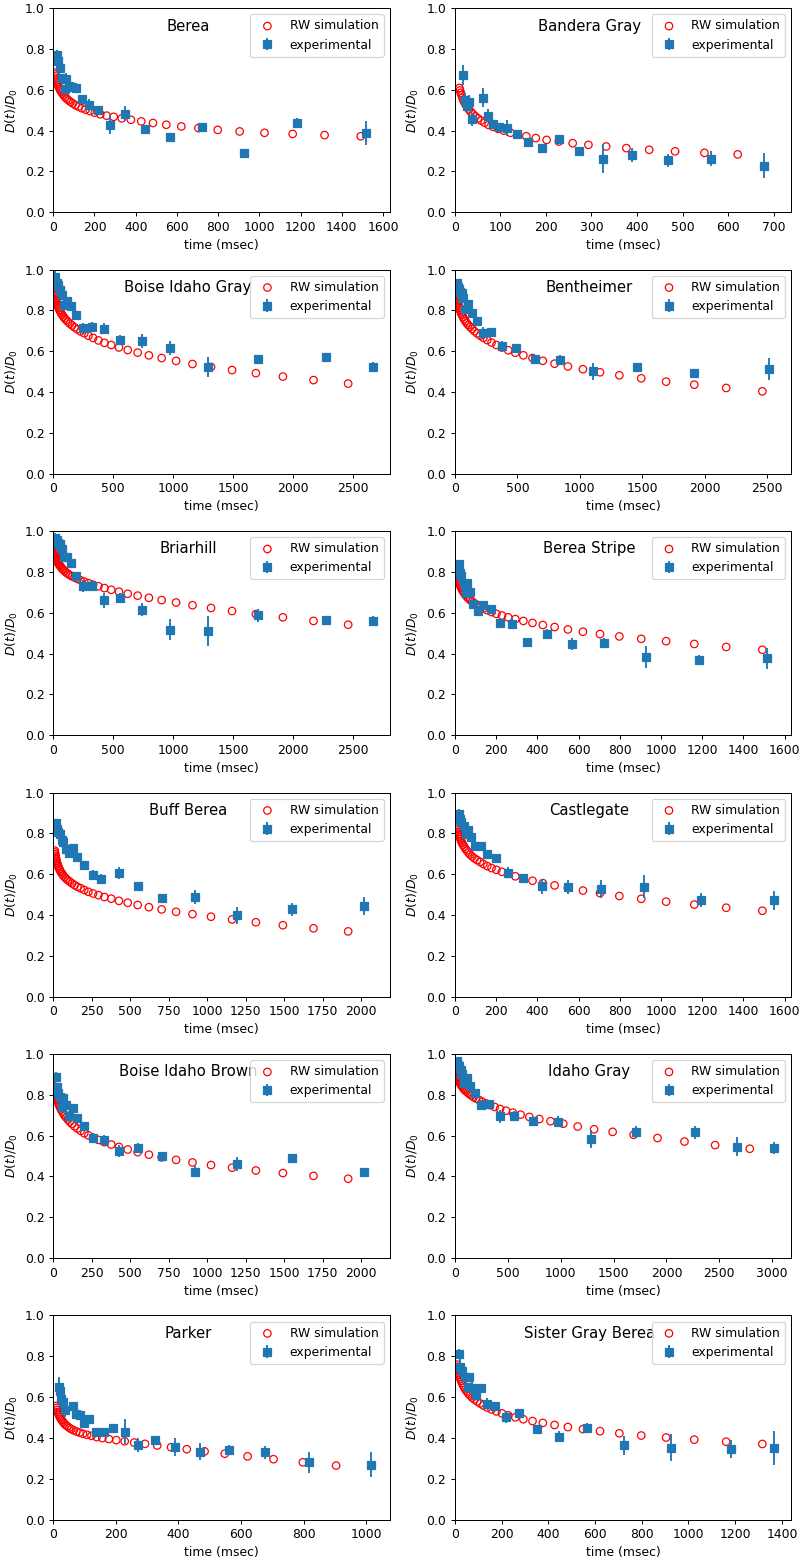

In [17]:
rows = int(np.ceil(len(to_be_showed) / 2))
cols = 2

if(len(to_be_showed) < 3):
    rows = len(to_be_showed)
    cols = 1

width = 5*cols
height = 3.25*rows
    
fig, axs = plt.subplots(rows,cols,figsize=(width,height),constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
    if(i < len(to_be_showed)):
        ax.set_title(titles[i],x=0.4, y=1, pad=-18)

        for index, row in df_sat.iterrows():
            if(row['sample'] == to_be_showed[i]):
                ax.scatter(
                    data['Time'][:row['mti']:3], 
                    row.iloc[1:-4].values[:row['mti']:3], 
                    marker='o', 
                    facecolors='none', 
                    edgecolors='r',
                    label=f"RW simulation")
                ax.set_xlim([0,1.05*data['Time'][row['mti']]])

        for d in exp_data:
            if(d['sample'] == to_be_showed[i]):
                ax.errorbar(d['data']['time'], d['data']['D_D0'], yerr=d['data']['uncertainty'], 
                            linestyle='', marker='s', label=f"experimental")

        ax.set_ylim([0,1])

        ax.set_xlabel('time (msec)')
        ax.set_ylabel(r'$D(t)/D_0$')
        ax.legend(loc='best', ncol=1)


In [ ]:
plt.savefig(fname=f"figs/Dt_comparison_{litotype}.svg", format="svg")
plt.savefig(fname=f"figs/Dt_comparison_{litotype}.png", format="png")

In [27]:
plt.close('all')

<IPython.core.display.Javascript object>


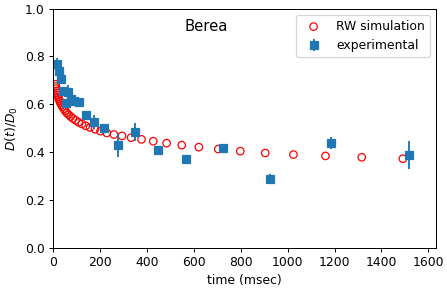

<IPython.core.display.Javascript object>


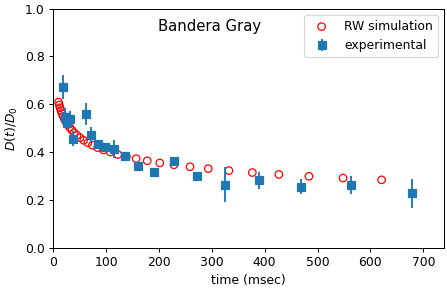

<IPython.core.display.Javascript object>


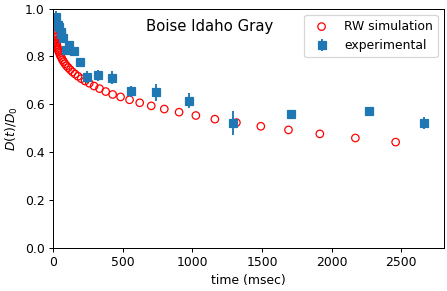

<IPython.core.display.Javascript object>


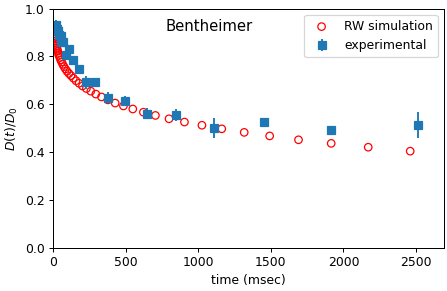

<IPython.core.display.Javascript object>


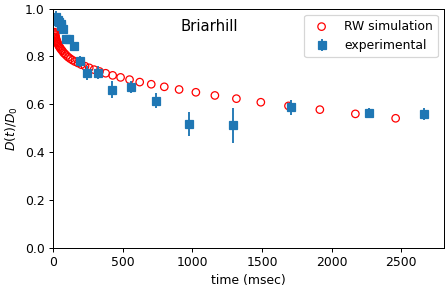

<IPython.core.display.Javascript object>


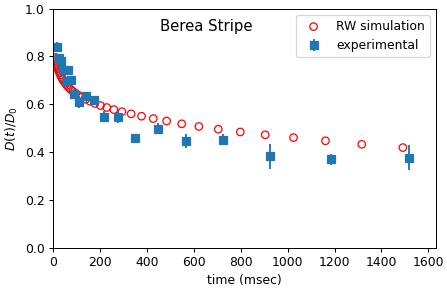

<IPython.core.display.Javascript object>


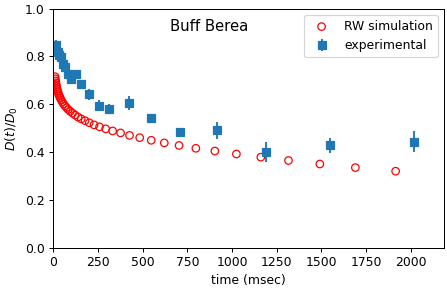

<IPython.core.display.Javascript object>


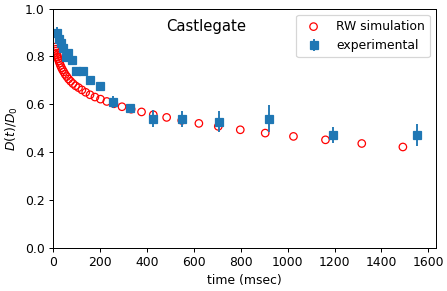

<IPython.core.display.Javascript object>


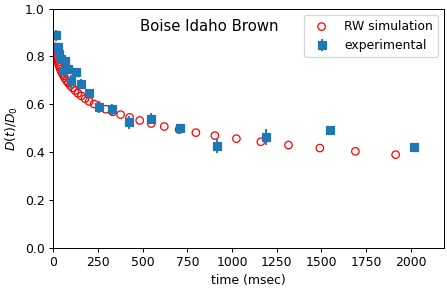

<IPython.core.display.Javascript object>


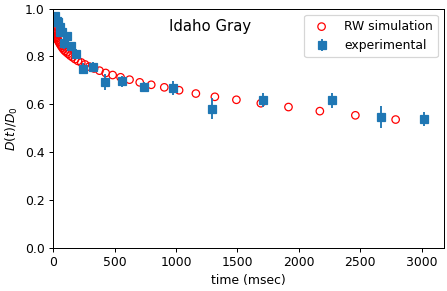

<IPython.core.display.Javascript object>


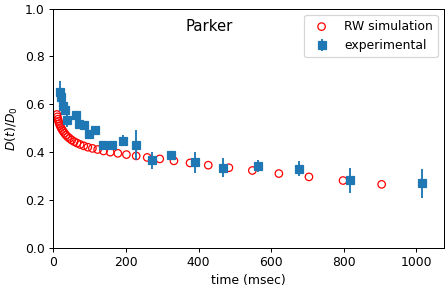

<IPython.core.display.Javascript object>


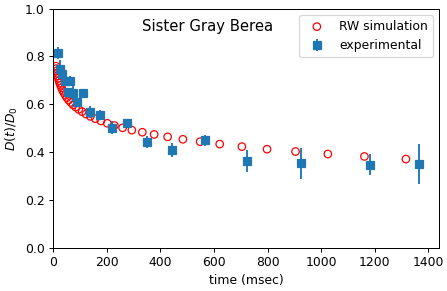

In [18]:

for i, sample in enumerate(to_be_showed):
    fig, axs = plt.subplots(1,1 ,figsize=(5,3.25),constrained_layout=True)
    axs.set_title(titles[i],x=0.4, y=1, pad=-18)

    for index, row in df_sat.iterrows():
        if(row['sample'] == to_be_showed[i]):
            axs.scatter(
                data['Time'][:row['mti']:3], 
                row.iloc[1:-4].values[:row['mti']:3], 
                marker='o', 
                facecolors='none', 
                edgecolors='r',
                label=f"RW simulation")
            axs.set_xlim([0,1.05*data['Time'][row['mti']]])

    for d in exp_data:
        if(d['sample'] == to_be_showed[i]):
            axs.errorbar(d['data']['time'], d['data']['D_D0'], yerr=d['data']['uncertainty'], 
                        linestyle='', marker='s', label=f"experimental")

    axs.set_ylim([0,1])
    
    axs.set_xlabel('time (msec)')
    axs.set_ylabel(r'$D(t)/D_0$')
    axs.legend(loc='best', ncol=1)
    plt.savefig(fname=f"figs/{litotype}/Dt_comparison_{sample}.svg", format="svg")
    plt.savefig(fname=f"figs/{litotype}/Dt_comparison_{sample}.png", format="png")
    plt.show()
    

In [17]:
plt.close('all')

# Comparing relaxivity effect

In [18]:
to_be_showed = sim_samples
titles = [tag2sample[s] for s in to_be_showed]

<IPython.core.display.Javascript object>


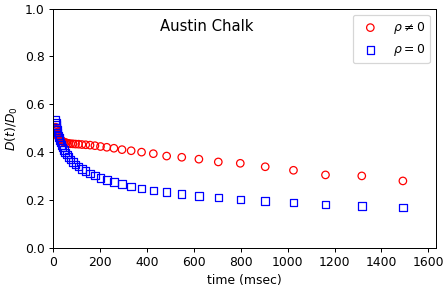

<IPython.core.display.Javascript object>


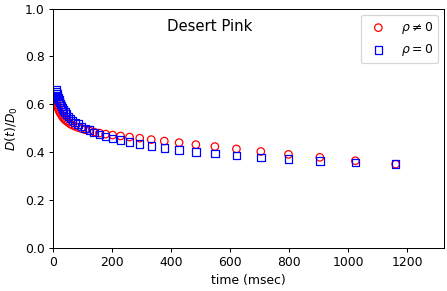

<IPython.core.display.Javascript object>


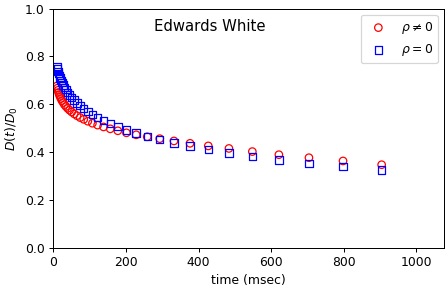

<IPython.core.display.Javascript object>


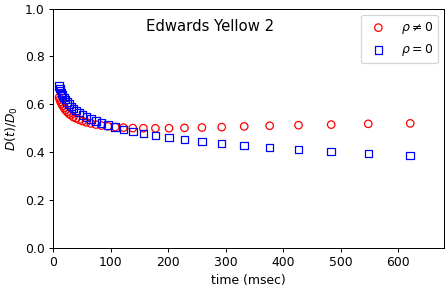

<IPython.core.display.Javascript object>


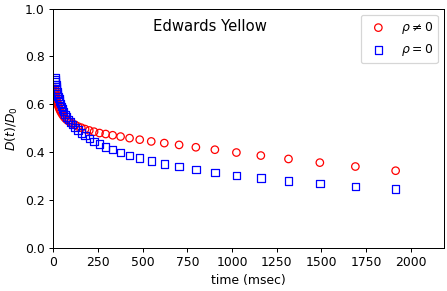

<IPython.core.display.Javascript object>


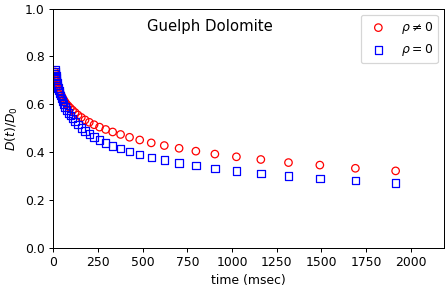

<IPython.core.display.Javascript object>


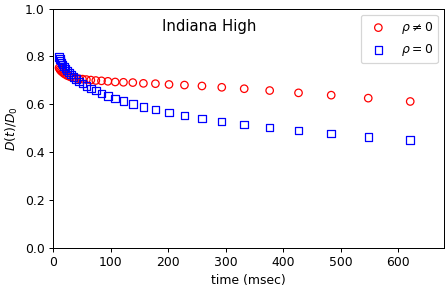

<IPython.core.display.Javascript object>


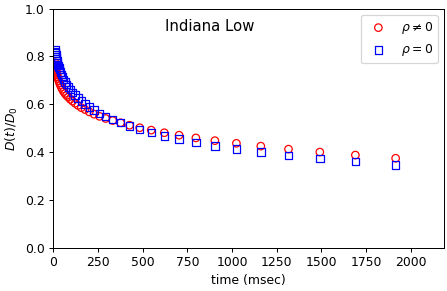

<IPython.core.display.Javascript object>


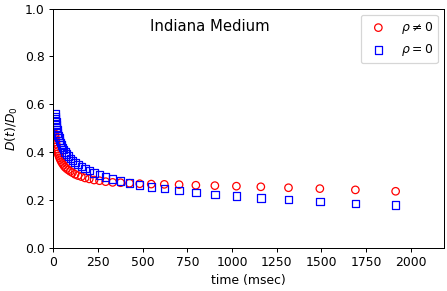

<IPython.core.display.Javascript object>


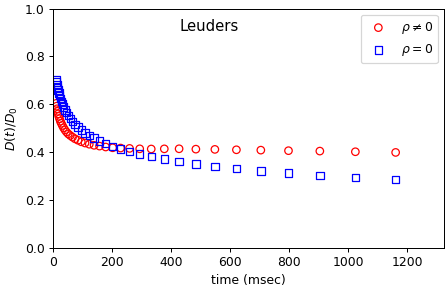

<IPython.core.display.Javascript object>


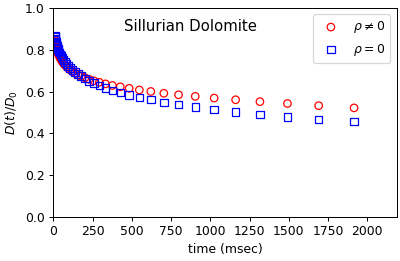

<IPython.core.display.Javascript object>


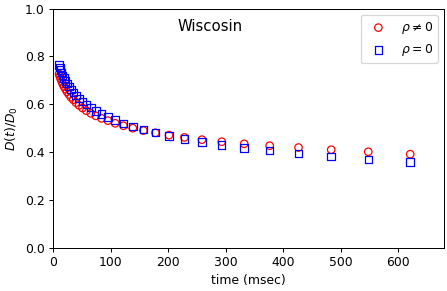

In [19]:

for i, sample in enumerate(to_be_showed):
    fig, axs = plt.subplots(1,1 ,figsize=(5,3.25),constrained_layout=True)
    axs.set_title(titles[i],x=0.4, y=1, pad=-18)

    for index, row in df_sat.iterrows():
        if(row['sample'] == to_be_showed[i]):
            axs.scatter(
                data['Time'][:row['mti']:3], 
                row.iloc[1:-4].values[:row['mti']:3], 
                marker='o', 
                facecolors='none', 
                edgecolors='r',
                label=r"$\rho \neq 0$")
            axs.set_xlim([0,1.05*data['Time'][row['mti']]])
    
    for index, row in df_msd.iterrows():
        if(row['sample'] == to_be_showed[i]):
            axs.scatter(
                data['Time'][:row['mti']:3], 
                row.iloc[1:-4].values[:row['mti']:3], 
                marker='s', 
                facecolors='none', 
                edgecolors='b',
                label=r"$\rho = 0$")
            axs.set_xlim([0,1.05*data['Time'][row['mti']]])



    axs.set_ylim([0,1])
    
    axs.set_xlabel('time (msec)')
    axs.set_ylabel(r'$D(t)/D_0$')
    axs.legend(loc='best', ncol=1)
    plt.savefig(fname=f"figs/{litotype}/Dt_method_{sample}.svg", format="svg")
    plt.savefig(fname=f"figs/{litotype}/Dt_method_{sample}.png", format="png")
    plt.show()
    

In [ ]:
to_be_showed = sim_samples
titles = [tag2sample[s] for s in to_be_showed]
rows = len(to_be_showed) // 2
cols = 2

if(len(to_be_showed) < 3):
    rows = len(to_be_showed)
    cols = 1

width = 5*cols
height = 3.25*rows
    
fig, axs = plt.subplots(rows,cols,figsize=(width,height),constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_title(titles[i],x=0.4, y=1, pad=-18)

    for index, row in df_sat.iterrows():
        if(row['sample'] == to_be_showed[i]):
            ax.scatter(
                data['Time'][:row['mti']], 
                row.iloc[1:-4].values[:row['mti']:1], 
                marker='o', 
                facecolors='none', 
                edgecolors='r',
                label=r"$\rho \neq 0$")
            ax.set_xlim([0,1.05*data['Time'][row['mti']]])
    
    for index, row in df_msd.iterrows():
        if(row['sample'] == to_be_showed[i]):
            ax.scatter(
                data['Time'][:row['mti']], 
                row.iloc[1:-4].values[:row['mti']:1], 
                marker='s', 
                facecolors='none', 
                edgecolors='b',
                label=r"$\rho = 0$")
            ax.set_xlim([0,1.05*data['Time'][row['mti']]])

    
    ax.set_ylim([0,1])
    
    ax.set_xlabel('time (msec)')
    ax.set_ylabel(r'$D(t)/D_0$')
    ax.legend(loc='best', ncol=1)


In [ ]:
plt.savefig(fname=f"figs/Dtsims_comparison_{litotype}.svg", format="svg")
plt.savefig(fname=f"figs/Dtsims_comparison_{litotype}.png", format="png")

In [ ]:
to_be_saved = ['BN', 'BR', 'BS', 'IB']

for index, row in df_sat.iterrows():
    if(row['sample'] in to_be_saved):
        time = data['Time'][:row['mti']]
        Dt = row.iloc[1:-4].values[:row['mti']:1] 
        df = pd.DataFrame({'time': time, 'Dt': Dt})
        df.to_csv(f"{row['sample']}_sim_results.csv", index=False, sep="\t")